In [1]:
import collections
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import matminer
import pymatgen.core.composition
import pymatgen.io.ase
from pymatgen.analysis.local_env import JmolNN

from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.structure.misc import EwaldEnergy
from matminer.featurizers.structure.order import StructuralComplexity
from matminer.featurizers.structure.symmetry import GlobalSymmetryFeatures
from matminer.featurizers.structure.bonding import GlobalInstabilityIndex
from matminer.featurizers.site.bonding import AverageBondLength

import pandas as pd
import swifter

RANDOM_SEED = 1234

pd.options.mode.chained_assignment = None
tqdm.tqdm.pandas()
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Data Cleaning

In [93]:
df = pd.read_pickle("../raw_data/2d_mat_dataset_raw.pkl")
total = len(df)
print(f"Starting with {total} entries. Includes top-down and bottom-up.")
      
# Throw out systems that are predicted to decompose
df = df[df["decomposition_energy (eV/atom)"] == 0]
print(f"Discarding {total-len(df)} entries predicted to decompose (Decomp energy != 0). Total is now {len(df)}.")
total = len(df)

# Remove systems containing f-block / synthetic elements
fblock_and_synth = ["La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu",
                    "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr",
                    "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Tg", "Cn", "Nh", "Fl", "Mc", "Mc", "Lv", "Ts", "Og"]
df = df[df["atoms_object (unitless)"].apply(
           lambda atoms: all(symbol not in fblock_and_synth for symbol in atoms.get_chemical_symbols()))
       ]
print(f"Discarding {total - len(df)} entries in the f-block, or synthetics. Total is now {len(df)}.")
total = len(df)

# Discard metallic systems
df = df[df["bandgap (eV)"] > 0]
print(f"Discarding {total - len(df)} entries that are metallic. Total is now {len(df)}.")
total = len(df)

# To keep the methodology consistent, discard systems where a U-correction was applied
df = df[df["is_hubbard (unitless)"] == False]
print(f"Discarding {total - len(df)} entries that have U-corrections applied (metal oxides/fluorides). Total is now {len(df)}.")
total = len(df)

# Throw out systems based on exfoliation energy
min_exfol = 0.0
max_exfol = 0.2
df = df[df["exfoliation_energy_per_atom (eV/atom)"].apply(lambda exfol: min_exfol < exfol <= max_exfol)]
print(f"Discarding {total - len(df)} entries outside {np.round(min_exfol,3)} < exfoliation energy <= {np.round(max_exfol,3)}. "
      f"Total is now {len(df)}.")

def is_MAX_structure(atoms):
    formula = set(atoms.get_chemical_symbols())
    
    m_symbols = ['Sc', 'Ti', 'V', 'Cr',
                 'Y', 'Zr', 'Nb', 'Mo',
                 'Hf', 'Ta', 'W']
    a_symbols = ['Al', 'Si', 'P,', 'S',
                 'Zn', 'Ga', 'Ge', 'As', 'Se',
                 'Cd', 'In', 'Sn', 'Sb', 'Te',
                 'Hg', 'Tl', 'Pb', 'Bi', 'Po']
    x_symbols = ['C', 'N', 'O']
    
    has_m = any(symbol in m_symbols for symbol in formula)
    has_a = any(symbol in a_symbols for symbol in formula)
    has_x = any(symbol in x_symbols for symbol in formula)
    
    return has_m and has_a and has_x

df[df["atoms_object (unitless)"].apply(lambda atoms: is_MAX_structure(atoms))]

Starting with 6351 entries. Includes top-down and bottom-up.
Discarding 5606 entries predicted to decompose (Decomp energy != 0). Total is now 745.
Discarding 135 entries in the f-block, or synthetics. Total is now 610.
Discarding 124 entries that are metallic. Total is now 486.
Discarding 25 entries that have U-corrections applied (metal oxides/fluorides). Total is now 461.
Discarding 74 entries outside 0.0 < exfoliation energy <= 0.2. Total is now 387.


,2dm_id (unitless),formula,discovery_process (unitless),atoms_object (unitless),potcars (unitless),is_hubbard (unitless),energy_per_atom (eV),decomposition_energy (eV/atom),exfoliation_energy_per_atom (eV/atom),energy_vdw_per_atom (eV/atom),...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
3961,2dm-3972,NbTlBr4O,top-down,"(Atom('Nb', [1.8144819313816958, 3.87564094000...","[PAW_PBE Nb_pv 08Apr2002, PAW_PBE Tl_d 06Sep20...",False,-4.652918,0.0,0.083385,-3.842165,...,1.0,2.0,0.128,0.02658,152.0,150.0,182.0,316.5,317.5,0.802
4346,2dm-4357,SnTiO3,top-down,"(Atom('Ti', [2.5559402440572, 1.47567266765919...","[PAW_PBE Ti_pv 07Sep2000, PAW_PBE Sn_d 06Sep20...",False,-7.695223,0.0,0.033226,-6.626305,...,2.0,2.0,0.222,0.02658,152.0,150.0,182.0,317.5,317.5,0.802
5334,2dm-5345,Ta2CS2,top-down,"(Atom('Ta', [3.29160515246842, 1.9004092502041...","[PAW_PBE Ta_pv 07Sep2000, PAW_PBE C 08Apr2002,...",False,-9.171035,0.0,0.042738,-8.521825,...,2.0,2.0,0.140,0.20500,170.0,177.0,204.0,317.0,3400.0,1.670


# Featurization

In [18]:
structures = df['atoms_object (unitless)'].apply(pymatgen.io.ase.AseAtomsAdaptor.get_structure)
df['ox_struct'] = structures.apply(lambda i: i.copy())

# struct.add_oxidation_state_by_guess() modifies the structure in-place
df.ox_struct.swifter.apply(lambda struct: struct.add_oxidation_state_by_guess())

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

2979    None
2983    None
3009    None
3031    None
3032    None
        ... 
5971    None
5972    None
5973    None
5974    None
5975    None
Name: ox_struct, Length: 92, dtype: object

In [19]:
struct_features = MultipleFeaturizer([
    EwaldEnergy(),
    StructuralComplexity(),
    GlobalSymmetryFeatures('n_symmetry_ops'),
])
df[struct_features.feature_labels()] = struct_features.featurize_many(df.ox_struct).copy()

MultipleFeaturizer:   0%|          | 0/92 [00:00<?, ?it/s]

In [20]:
desc = GlobalInstabilityIndex()

def maybe_global_instability(struct):
    try:
        return desc.featurize(struct)[0]
    except:
        return None

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df['global_instability'] = df.ox_struct.swifter.apply(maybe_global_instability).copy()

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

In [21]:
neighbor_finder = JmolNN()

def average_bond_length(structure, featurizer = AverageBondLength(neighbor_finder)):
    n_atoms = len(structure)
    try:
        lengths = map(lambda i: featurizer.featurize(structure, i)[0], range(n_atoms))
        return sum(lengths) / n_atoms
    except IndexError:
        return None

df['bond_length_average'] = df.ox_struct.swifter.apply(average_bond_length).copy()

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

In [22]:
from matminer.featurizers.site.bonding import AverageBondAngle

def average_bond_angle(structure, featurizer = AverageBondAngle(neighbor_finder)):
    n_atoms = len(structure)
    try:
        angles = map(lambda i: featurizer.featurize(structure, i)[0], range(n_atoms))
        return sum(angles) / n_atoms
    except IndexError:
        return None
df['bond_angle_average'] = df.ox_struct.swifter.apply(average_bond_angle).copy()

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/matminer/featurizers/site/bonding.py:250: RuntimeWarning: All-NaN slice encountered
  minimum_bond_angles = np.nanmin(bond_angles, axis=1)


In [23]:
def average_cn(structure, neighbor_finder = neighbor_finder):
    n_atoms = len(structure)
    cns = map(lambda i: neighbor_finder.get_cn(structure, i), range(n_atoms))
    return sum(cns) / n_atoms
df['average_cn'] = df.ox_struct.swifter.apply(average_cn).copy()

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

In [24]:
def ab_perimeter_area_ratio(structure):
    a, b, c = structure.lattice.matrix
    perimeter = 2*np.linalg.norm(a) + 2*np.linalg.norm(b)
    area = np.linalg.norm(np.cross(a,b))
    return perimeter / area
df['perimeter_area_ratio'] = df.ox_struct.swifter.apply(ab_perimeter_area_ratio).copy()

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

In [25]:
df["formula"] = df["atoms_object (unitless)"].swifter.apply(lambda atoms: atoms.get_chemical_formula(empirical=True))

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

In [26]:
#df.to_pickle("all_descriptors.pkl")

object_cols = ["atoms_object (unitless)",
               "ox_struct"]

regression_irrelevant = object_cols + [
    'discovery_process (unitless)',
    'potcars (unitless)',
    'is_hubbard (unitless)',
    'energy_per_atom (eV)',
    'decomposition_energy (eV/atom)',
    'is_bandgap_direct (unitless)',
    'is_metal (unitless)',
    'energy_vdw_per_atom (eV/atom)',
    'total_magnetization (Bohr Magneton)']

#df.drop(columns=object_cols).to_csv("both_extra_descriptors.csv")

# Chemical Info

In [12]:
for allowed_symbols, set_name in [
    [["N"], "nitrides"],
    [["O"], "oxides"],
    [["S"], "sulfides"],
    [["C"], "carbides"],
    [["F", "Cl", "Br", "Cl"], "halides"],
    [["O", "S", "Se", "Te"], "chalcogens"],
    [["N", "O", "As", "Sb"], "pnictogens"],
    [["Al", "Ga", "Ge", "In", "Sn", "Sb", "Tl", "Pb", "Bi", "Po"], "pBlockMetals"]
]:
    fun = lambda atoms: any(symbol in allowed_symbols for symbol in atoms.get_chemical_symbols())
    filtered = df[df["atoms_object (unitless)"].swifter.apply(fun)]
    filtered.drop(columns=object_cols).to_csv(f"both_{set_name}Only.csv")

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

In [13]:
# Based on https://en.wikipedia.org/wiki/Wide-bandgap_semiconductor and https://www.kymatech.com/about/faqs/429-what-is-an-ultra-wide-bandgap-semiconductor-material
df[df["bandgap (eV)"].swifter.apply(lambda bg: 0 < bg < 2)].drop(columns=object_cols).to_csv("both_conventionalSemiconductorsOnly.csv")
df[df["bandgap (eV)"].swifter.apply(lambda bg: 2 <= bg <= 3.4)].drop(columns=object_cols).to_csv("both_WBGOnly.csv")
df[df["bandgap (eV)"].swifter.apply(lambda bg: 3.4 < bg < 10)].drop(columns=object_cols).to_csv("both_UWBGOnly.csv")

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

In [80]:
import sklearn.model_selection
import tpot

data_train, data_test = sklearn.model_selection.train_test_split(df.drop(columns=regression_irrelevant + ['formula', '2dm_id (unitless)', 'exfoliation_energy_per_atom (eV/atom)']), test_size=0.25, random_state=RANDOM_SEED)
train_x = data_train.drop(columns="bandgap (eV)").to_numpy().astype(np.float64)
train_y = data_train["bandgap (eV)"].dropna().to_numpy()

test_x = data_test.drop(columns="bandgap (eV)").to_numpy().astype(np.float64)
test_y = data_test["bandgap (eV)"].to_numpy()

In [82]:
model = tpot.TPOTRegressor(
    generations=None,
    population_size=100,
    max_eval_time_mins=10/60,
    max_time_mins=20,
    cv=5,
    verbosity=2,
    scoring="neg_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=4,
    random_state=RANDOM_SEED
)
model.fit(features=train_x, target=train_y)

Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.5448982894469013


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=4, min_samples_leaf=15, min_samples_split=11)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

Imputing missing values in feature set
Imputing missing values in feature set


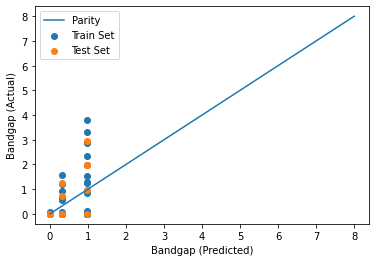

In [83]:
train_y_pred = model.predict(train_x)
test_y_pred = model.predict(test_x)

plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
plt.scatter(x=test_y_pred, y=test_y, label="Test Set")
plt.plot([0,8], [0,8], label="Parity")
plt.ylabel("Bandgap (Actual)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()

In [ ]:
colmask = [":" not in i for i in df.columns]
masked_df = df[df.columns[colmask]]
masked_df.drop(columns=to_drop + ["2dm_id (unitless)", "formula", "exfoliation_energy_per_atom (eV/atom)", "kmeans_cluster"])

In [70]:
train_x

array([], shape=(0, 299), dtype=float64)

In [76]:
train_x

array([], shape=(0, 299), dtype=float64)